# Abstract
{TEXT}

# Content
{TEXT}

In [1]:
# environment requirement:
# conda env create --name sparkbeyond -f environment.yml
# conda activate sparkbeyond

# 1. Introduction
Problem statement

# 2. Exploratory data anlysis and Data Wrangling

In [1]:
import pandas as pd
import numpy as np
from sklearn import ensemble, preprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/juyang/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Load dataset 
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
sample = pd.read_csv('input/sampleSubmission.csv')

weather = pd.read_csv('input/weather.csv')
spray = pd.read_csv('input/spray.csv')

In [110]:
test.dtypes

Id                          int64
Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
dtype: object

In [4]:
# weather station coordinates
station1 = [-87.933 , 41.995]
station2 = [-87.752 , 41.786]

In [5]:
N_train = len(train)
N_test  = len(test)
N_weather = len(weather)
N_spray = len(spray)
# missing value, no missing data NaN in train, test, and weather
# missing time in spray
N_missing_time = spray.isna().sum().Time
perc_missing_time = 1.*N_missing_time / N_spray
print ("Number of training data: %d"%N_train)
print ("Number of testing data: %d"%N_test)
print ("Number of weather records: %d"%N_weather)
print ("Number of spray reords: %d"%N_spray)
print ("Number of spray records with missing time: %d, %.2f of all spray records"%(N_missing_time, perc_missing_time))

Number of training data: 10506
Number of testing data: 116293
Number of weather records: 2944
Number of spray reords: 14835
Number of spray records with missing time: 584, 0.04 of all spray records


In [6]:
# class distribution is imbalanced, may use oversampling or downsampling for model training
labels = train.WnvPresent.value_counts()
neg_class = labels[0]
pos_class = labels[1]
ratio = 1.*neg_class / pos_class
print ("Number of negative virus presence: %d"%neg_class)
print ("Number of positive virus presence: %d"%pos_class)
print ("Negative to positive class ratio: %.1f"%ratio)

Number of negative virus presence: 9955
Number of positive virus presence: 551
Negative to positive class ratio: 18.1


Data collection:
Every year from late-May to early-October, public health workers in Chicago setup mosquito traps scattered across the city. Every week from Monday through Wednesday, these traps collect mosquitos, and the mosquitos are tested for the presence of West Nile virus before the end of the week. 
The test results include 
- the number of mosquitos
    - These test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. 
- the mosquitos species
- whether or not West Nile virus is present in the cohort. 

The location of the traps are described by:
- block number, street name. For your convenience, we have mapped these attributes into Longitude and Latitude in the dataset. Please note that these are derived locations. 
- For example, Block=79, and Street= "W FOSTER AVE" gives us an approximate address of "7900 W FOSTER AVE, Chicago, IL", which translates to (41.974089,-87.824812) on the map.
- Some traps are "satellite traps". These are traps that are set up near (usually within 6 blocks) an established trap to enhance surveillance efforts. Satellite traps are postfixed with letters. For example, T220A is a satellite trap to T220B.
- Please note that not all the locations are tested at all times. Also, records exist only when a particular species of mosquitos is found at a certain trap at a certain time. In the test set, we ask you for all combinations/permutations of possible predictions and are only scoring the observed ones.

Spray Data ==> reduce all mosquitos in the area
- The City of Chicago also does spraying to kill mosquitos. You are given the GIS data for their spray efforts in 2011 and 2013. Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus.

## check missing values

In [7]:
train.dtypes

Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
dtype: object

In [8]:
test.dtypes

Id                          int64
Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
dtype: object

In [9]:
train.isna().sum()
# no missing values for training trap

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

In [10]:
test.isna().sum()

Id                        0
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
dtype: int64

In [11]:
weather.isna().sum() 
# it appears there is no missing value, however, dtypes for certain numerical values is object
# suggesting there are missing data for certain columns

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [12]:
weather.dtypes

Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg            object
Depart          object
DewPoint         int64
WetBulb         object
Heat            object
Cool            object
Sunrise         object
Sunset          object
CodeSum         object
Depth           object
Water1          object
SnowFall        object
PrecipTotal     object
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed        object
dtype: object

In [13]:
obj_columns = weather.select_dtypes(include=['object']).columns
obj_columns 
# except "Date", all others seems to be numeric values

Index(['Date', 'Tavg', 'Depart', 'WetBulb', 'Heat', 'Cool', 'Sunrise',
       'Sunset', 'CodeSum', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'AvgSpeed'],
      dtype='object')

In [14]:
def count_missing_value(df, col, missing_values = ['M','-','T','']):
    missing_dict = dict()
    for missing_value in missing_values:
        # not need strip empty space first
        df[col] = df[col].apply(lambda x: str(x).strip())
        cnt = len(df[df[col] == missing_value])
        missing_dict [missing_value] = cnt
    print ("missing values for %s"%col)
    print (missing_dict)

In [15]:
print ("total records in weather data is", len(weather))
weather2 = weather.copy()
for col in obj_columns:
    if col != "Date":
        count_missing_value(weather2, col)

total records in weather data is 2944
missing values for Tavg
{'M': 11, '-': 0, 'T': 0, '': 0}
missing values for Depart
{'M': 1472, '-': 0, 'T': 0, '': 0}
missing values for WetBulb
{'M': 4, '-': 0, 'T': 0, '': 0}
missing values for Heat
{'M': 11, '-': 0, 'T': 0, '': 0}
missing values for Cool
{'M': 11, '-': 0, 'T': 0, '': 0}
missing values for Sunrise
{'M': 0, '-': 1472, 'T': 0, '': 0}
missing values for Sunset
{'M': 0, '-': 1472, 'T': 0, '': 0}
missing values for CodeSum
{'M': 0, '-': 0, 'T': 0, '': 1609}
missing values for Depth
{'M': 1472, '-': 0, 'T': 0, '': 0}
missing values for Water1
{'M': 2944, '-': 0, 'T': 0, '': 0}
missing values for SnowFall
{'M': 1472, '-': 0, 'T': 12, '': 0}
missing values for PrecipTotal
{'M': 2, '-': 0, 'T': 318, '': 0}
missing values for StnPressure
{'M': 4, '-': 0, 'T': 0, '': 0}
missing values for SeaLevel
{'M': 9, '-': 0, 'T': 0, '': 0}
missing values for AvgSpeed
{'M': 3, '-': 0, 'T': 0, '': 0}


When it comes to liquid precipitation (rainfall), meteorologists don't measure anything under 0.01 inch (one hundredth of an inch). 

In [16]:
# deal with trace
trace = 0.005
weather['SnowFall'] = weather['SnowFall'].apply(lambda x: trace if 'T' in x else x)
weather['PrecipTotal'] = weather['PrecipTotal'].apply(lambda x: trace if 'T' in x else x)
weather.SnowFall.value_counts()

M        1472
0.0      1459
0.005      12
0.1         1
Name: SnowFall, dtype: int64

In [17]:
weather.drop(['Water1'],inplace=True,axis=1)

As we can see, these columns use 'M', '-', and ' ' to represent missing values, and use 'T' to represent trace (small amount).
We can replace the missing value with other numeric values, and replace 'T' with small amount of data.
- Tavg only has 11 missing rows
- Depart, Sunrise, Sunset, Depth, SnowFall have half data missing
- Water1 is all mising, remove from weather
- SnowFall and PrecipTotal have Trace data
- CodeSum uses empty string to represent missing values
- Other columns have small amount of missing data
It seems station 1 have fewer missing values, replace station 2 with station 1.

In [18]:
# seperate 2 station's data
s1 = weather[weather['Station'] == 1].copy()
s2 = weather[weather['Station'] == 2].copy()

In [19]:
s1.dtypes

Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg            object
Depart          object
DewPoint         int64
WetBulb         object
Heat            object
Cool            object
Sunrise         object
Sunset          object
CodeSum         object
Depth           object
SnowFall        object
PrecipTotal     object
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed        object
dtype: object

In [20]:
s2_merge_s1 = pd.merge(s1,s2,on='Date')
s2_merge_s1.columns

Index(['Station_x', 'Date', 'Tmax_x', 'Tmin_x', 'Tavg_x', 'Depart_x',
       'DewPoint_x', 'WetBulb_x', 'Heat_x', 'Cool_x', 'Sunrise_x', 'Sunset_x',
       'CodeSum_x', 'Depth_x', 'SnowFall_x', 'PrecipTotal_x', 'StnPressure_x',
       'SeaLevel_x', 'ResultSpeed_x', 'ResultDir_x', 'AvgSpeed_x', 'Station_y',
       'Tmax_y', 'Tmin_y', 'Tavg_y', 'Depart_y', 'DewPoint_y', 'WetBulb_y',
       'Heat_y', 'Cool_y', 'Sunrise_y', 'Sunset_y', 'CodeSum_y', 'Depth_y',
       'SnowFall_y', 'PrecipTotal_y', 'StnPressure_y', 'SeaLevel_y',
       'ResultSpeed_y', 'ResultDir_y', 'AvgSpeed_y'],
      dtype='object')

In [21]:
print ("total records in weather data is", len(s2_merge_s1))
s3 = s2_merge_s1.copy()
cols = s3.columns
for col in cols:
    if "Date" not in col:
        count_missing_value(s3, col)
# use the nearest data if possible

total records in weather data is 1472
missing values for Station_x
{'M': 0, '-': 0, 'T': 0, '': 0}
missing values for Tmax_x
{'M': 0, '-': 0, 'T': 0, '': 0}
missing values for Tmin_x
{'M': 0, '-': 0, 'T': 0, '': 0}
missing values for Tavg_x
{'M': 0, '-': 0, 'T': 0, '': 0}
missing values for Depart_x
{'M': 0, '-': 0, 'T': 0, '': 0}
missing values for DewPoint_x
{'M': 0, '-': 0, 'T': 0, '': 0}
missing values for WetBulb_x
{'M': 3, '-': 0, 'T': 0, '': 0}
missing values for Heat_x
{'M': 0, '-': 0, 'T': 0, '': 0}
missing values for Cool_x
{'M': 0, '-': 0, 'T': 0, '': 0}
missing values for Sunrise_x
{'M': 0, '-': 0, 'T': 0, '': 0}
missing values for Sunset_x
{'M': 0, '-': 0, 'T': 0, '': 0}
missing values for CodeSum_x
{'M': 0, '-': 0, 'T': 0, '': 805}
missing values for Depth_x
{'M': 0, '-': 0, 'T': 0, '': 0}
missing values for SnowFall_x
{'M': 0, '-': 0, 'T': 0, '': 0}
missing values for PrecipTotal_x
{'M': 0, '-': 0, 'T': 0, '': 0}
missing values for StnPressure_x
{'M': 2, '-': 0, 'T': 0, 

station1:
missing values for WetBulb_x
{'M': 3, '-': 0, 'T': 0, '': 0}
missing values for CodeSum_x
{'M': 0, '-': 0, 'T': 0, '': 805}
missing values for Water1_x
{'M': 1472, '-': 0, 'T': 0, '': 0}
missing values for StnPressure_x
{'M': 2, '-': 0, 'T': 0, '': 0}
missing values for SeaLevel_x
{'M': 5, '-': 0, 'T': 0, '': 0}

station2:
missing values for Tavg_y
{'M': 11, '-': 0, 'T': 0, '': 0}
missing values for Depart_y
{'M': 1472, '-': 0, 'T': 0, '': 0}
missing values for WetBulb_y
{'M': 1, '-': 0, 'T': 0, '': 0}
missing values for Heat_y
{'M': 11, '-': 0, 'T': 0, '': 0}
missing values for Cool_y
{'M': 11, '-': 0, 'T': 0, '': 0}
missing values for Sunrise_y
{'M': 0, '-': 1472, 'T': 0, '': 0}
missing values for Sunset_y
{'M': 0, '-': 1472, 'T': 0, '': 0}
missing values for CodeSum_y
{'M': 0, '-': 0, 'T': 0, '': 804}
missing values for Depth_y
{'M': 1472, '-': 0, 'T': 0, '': 0}
missing values for SnowFall_y
{'M': 1472, '-': 0, 'T': 0, '': 0}
missing values for PrecipTotal_y
{'M': 2, '-': 0, 'T': 0, '': 0}
missing values for StnPressure_y
{'M': 2, '-': 0, 'T': 0, '': 0}
missing values for SeaLevel_y
{'M': 4, '-': 0, 'T': 0, '': 0}
missing values for AvgSpeed_y
{'M': 3, '-': 0, 'T': 0, '': 0}

In [22]:
s3['Tavg_y'] = np.where((s3['Tavg_y'] == "M") | (s3['Tavg_y'] == "-" ), s3['Tavg_x'], s3['Tavg_y'])
s3['Depart_y'] = np.where( (s3['Depart_y'] == "M" ) | (s3['Depart_y'] == "-" ), s3['Depart_x'], s3['Depart_y'])
s3['Heat_y'] = np.where( (s3['Heat_y'] == "M" ) | (s3['Heat_y'] == "-" ), s3['Heat_x'], s3['Heat_y'])
s3['Cool_y'] = np.where( (s3['Cool_y'] == "M" ) | (s3['Cool_y'] == "-" ), s3['Cool_x'], s3['Cool_y'])
s3['Sunrise_y'] = np.where( (s3['Sunrise_y'] == "M" ) | (s3['Sunrise_y'] == "-" ), s3['Sunrise_x'], s3['Sunrise_y'])
s3['Sunset_y'] = np.where( (s3['Sunset_y'] == "M" ) | (s3['Sunset_y'] == "-" ), s3['Sunset_x'], s3['Sunset_y'])
s3['Depth_y'] = np.where( (s3['Depth_y'] == "M" ) | (s3['Depth_y'] == "-" ), s3['Depth_x'], s3['Depth_y'])
s3['SnowFall_y'] = np.where( (s3['SnowFall_y'] == "M" ) | (s3['SnowFall_y'] == "-" ), s3['SnowFall_x'], s3['SnowFall_y'])
s3['PrecipTotal_y'] = np.where( (s3['PrecipTotal_y'] == "M" ) | (s3['PrecipTotal_y'] == "-" ), s3['PrecipTotal_x'], s3['PrecipTotal_y'])
s3['AvgSpeed_y'] = np.where( (s3['AvgSpeed_y'] == "M" ) | (s3['AvgSpeed_y'] == "-" ), s3['AvgSpeed_x'], s3['AvgSpeed_y'])

station1:
missing values for WetBulb_x
{'M': 3, '-': 0, 'T': 0, '': 0}
missing values for CodeSum_x
{'M': 0, '-': 0, 'T': 0, '': 805}
missing values for StnPressure_x
{'M': 2, '-': 0, 'T': 0, '': 0}
missing values for SeaLevel_x
{'M': 5, '-': 0, 'T': 0, '': 0}

station2:
missing values for WetBulb_y
{'M': 1, '-': 0, 'T': 0, '': 0}
missing values for CodeSum_y
{'M': 0, '-': 0, 'T': 0, '': 804}
missing values for StnPressure_y
{'M': 2, '-': 0, 'T': 0, '': 0}
missing values for SeaLevel_y
{'M': 4, '-': 0, 'T': 0, '': 0}

In [23]:
# inspect all other missing values, whether both are empty

In [24]:
len(s3[(s3['WetBulb_x'] == "M") & (s3['WetBulb_y'] == "M")])

0

In [25]:
len(s3[(s3['CodeSum_x'] == "") & (s3['CodeSum_y'] == "")])

717

In [26]:
len(s3[(s3['StnPressure_x'] == "M") & (s3['StnPressure_y'] == "M")])

1

In [27]:
len(s3[(s3['SeaLevel_y'] == "M") & (s3['SeaLevel_y'] == "M")])

4

In [28]:
# replace with each other

In [29]:
s3['WetBulb_x'] = np.where((s3['WetBulb_x'] == "M"), s3['WetBulb_y'], s3['WetBulb_x'])
s3['WetBulb_y'] = np.where((s3['WetBulb_y'] == "M"), s3['WetBulb_x'], s3['WetBulb_y'])
s3['CodeSum_x'] = np.where((s3['CodeSum_x'] == ""), s3['CodeSum_y'], s3['CodeSum_x'])
s3['CodeSum_y'] = np.where((s3['CodeSum_y'] == ""), s3['CodeSum_x'], s3['CodeSum_y'])
s3['StnPressure_x'] = np.where((s3['StnPressure_x'] =="M"), s3['StnPressure_y'], s3['StnPressure_x'])
s3['StnPressure_y'] = np.where((s3['StnPressure_y'] =="M"), s3['StnPressure_x'], s3['StnPressure_y'])
s3['SeaLevel_x'] = np.where((s3['SeaLevel_x'] =="M"), s3['SeaLevel_y'], s3['SeaLevel_x'])
s3['SeaLevel_y'] = np.where((s3['SeaLevel_y'] =="M"), s3['SeaLevel_x'], s3['SeaLevel_y'])

for codesum, need to convert to one-hot encodding because it is a list of categories, but for now, let's not use it yet

for stn pressure, there is one instance when both have missing values

In [30]:
def not_missing_value_dist(df, col):
    not_missing = df[df[col] != 'M'].copy()
    not_missing[col] = not_missing[col].astype(float)
    not_missing[col].hist()
    print (not_missing[col].describe()) # normal distribution, use mean to represent the missing data
    return not_missing[col].mean()

count    1471.000000
mean       29.254167
std         0.156100
min        28.550000
25%        29.160000
50%        29.260000
75%        29.350000
max        29.790000
Name: StnPressure_x, dtype: float64


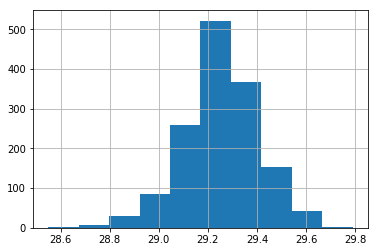

In [31]:
mean_StnPressure_x = not_missing_value_dist(s3, 'StnPressure_x')

count    1471.000000
mean       29.314684
std         0.155126
min        28.630000
25%        29.230000
50%        29.320000
75%        29.410000
max        29.860000
Name: StnPressure_y, dtype: float64


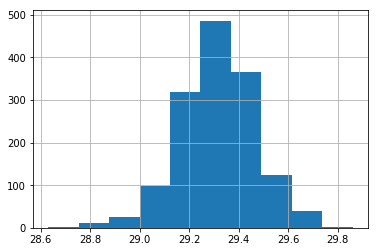

In [32]:
mean_StnPressure_y = not_missing_value_dist(s3, 'StnPressure_y')

count    1472.000000
mean       29.972738
std         0.158065
min        29.250000
25%        29.880000
50%        29.980000
75%        30.070000
max        30.520000
Name: SeaLevel_x, dtype: float64


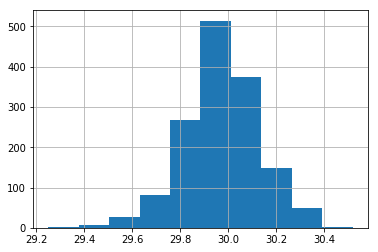

In [33]:
mean_SeaLevel_x = not_missing_value_dist(s3, 'SeaLevel_x')

count    1472.000000
mean       29.963811
std         0.158836
min        29.230000
25%        29.870000
50%        29.970000
75%        30.060000
max        30.530000
Name: SeaLevel_y, dtype: float64


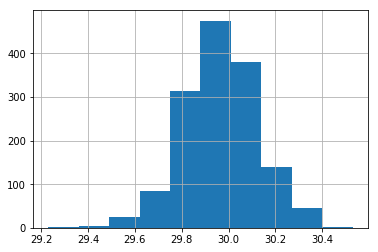

In [34]:
mean_SeaLevel_y = not_missing_value_dist(s3, 'SeaLevel_y')

In [35]:
s3['StnPressure_x'] = np.where((s3['StnPressure_x'] =="M"), mean_StnPressure_x, s3['StnPressure_x'])
s3['StnPressure_y'] = np.where((s3['StnPressure_y'] =="M"), mean_StnPressure_y, s3['StnPressure_y'])
s3['SeaLevel_x'] = np.where((s3['SeaLevel_x'] =="M"), mean_SeaLevel_x, s3['SeaLevel_x'])
s3['SeaLevel_y'] = np.where((s3['SeaLevel_y'] =="M"), mean_SeaLevel_y, s3['SeaLevel_y'])

In [36]:
# not consider codeSum for now
s3.columns

Index(['Station_x', 'Date', 'Tmax_x', 'Tmin_x', 'Tavg_x', 'Depart_x',
       'DewPoint_x', 'WetBulb_x', 'Heat_x', 'Cool_x', 'Sunrise_x', 'Sunset_x',
       'CodeSum_x', 'Depth_x', 'SnowFall_x', 'PrecipTotal_x', 'StnPressure_x',
       'SeaLevel_x', 'ResultSpeed_x', 'ResultDir_x', 'AvgSpeed_x', 'Station_y',
       'Tmax_y', 'Tmin_y', 'Tavg_y', 'Depart_y', 'DewPoint_y', 'WetBulb_y',
       'Heat_y', 'Cool_y', 'Sunrise_y', 'Sunset_y', 'CodeSum_y', 'Depth_y',
       'SnowFall_y', 'PrecipTotal_y', 'StnPressure_y', 'SeaLevel_y',
       'ResultSpeed_y', 'ResultDir_y', 'AvgSpeed_y'],
      dtype='object')

In [37]:
s1_new = s3[['Station_x', 'Date', 'Tmax_x', 'Tmin_x', 'Tavg_x', 'Depart_x',
       'DewPoint_x', 'WetBulb_x', 'Heat_x', 'Cool_x', 'Sunrise_x', 'Sunset_x',
       'Depth_x', 'SnowFall_x', 'PrecipTotal_x', 'StnPressure_x',
       'SeaLevel_x', 'ResultSpeed_x', 'ResultDir_x', 'AvgSpeed_x']].copy()
s2_new = s3[['Station_y','Date',
       'Tmax_y', 'Tmin_y', 'Tavg_y', 'Depart_y', 'DewPoint_y', 'WetBulb_y',
       'Heat_y', 'Cool_y', 'Sunrise_y', 'Sunset_y', 'Depth_y',
       'SnowFall_y', 'PrecipTotal_y', 'StnPressure_y', 'SeaLevel_y',
       'ResultSpeed_y', 'ResultDir_y', 'AvgSpeed_y']].copy()
# rename column later, but for now, keep it
# transform dataype to numerical
s1_new.rename(columns = {'Station_x':'Station',
'Date':'Date',
'Tmax_x':'Tmax',
'Tmin_x':'Tmin',
'Tavg_x':'Tavg',
'Depart_x':'Depart',
'DewPoint_x':'DewPoint',
'WetBulb_x':'WetBulb',
'Heat_x':'Heat',
'Cool_x':'Cool',
'Sunrise_x':'Sunrise',
'Sunset_x':'Sunset',
'Depth_x':'Depth',
'SnowFall_x':'SnowFall',
'PrecipTotal_x':'PrecipTotal',
'StnPressure_x':'StnPressure',
'SeaLevel_x':'SeaLevel',
'ResultSpeed_x':'ResultSpeed',
'ResultDir_x':'ResultDir',
'AvgSpeed_x':'AvgSpeed'},inplace=True)
s2_new.rename(columns = {'Station_y':'Station',
'Date':'Date',
'Tmax_y':'Tmax',
'Tmin_y':'Tmin',
'Tavg_y':'Tavg',
'Depart_y':'Depart',
'DewPoint_y':'DewPoint',
'WetBulb_y':'WetBulb',
'Heat_y':'Heat',
'Cool_y':'Cool',
'Sunrise_y':'Sunrise',
'Sunset_y':'Sunset',
'Depth_y':'Depth',
'SnowFall_y':'SnowFall',
'PrecipTotal_y':'PrecipTotal',
'StnPressure_y':'StnPressure',
'SeaLevel_y':'SeaLevel',
'ResultSpeed_y':'ResultSpeed',
'ResultDir_y':'ResultDir',
'AvgSpeed_y':'AvgSpeed'},inplace=True)

In [38]:
weather_new = s1_new.append(s2_new)
weather_new.dtypes

Station        object
Date           object
Tmax           object
Tmin           object
Tavg           object
Depart         object
DewPoint       object
WetBulb        object
Heat           object
Cool           object
Sunrise        object
Sunset         object
Depth          object
SnowFall       object
PrecipTotal    object
StnPressure    object
SeaLevel       object
ResultSpeed    object
ResultDir      object
AvgSpeed       object
dtype: object

In [39]:
weather_new['Station'] = weather_new['Station'].astype(int)
weather_new['Tmax'] = weather_new['Tmax'].astype(int)
weather_new['Tmin'] = weather_new['Tmin'].astype(int)
weather_new['Tavg'] = weather_new['Tavg'].astype(int)
weather_new['Depart'] = weather_new['Depart'].astype(int)
weather_new['DewPoint'] = weather_new['DewPoint'].astype(int)
weather_new['WetBulb'] = weather_new['WetBulb'].astype(int)
weather_new['Heat'] = weather_new['Heat'].astype(int)
weather_new['Cool'] = weather_new['Cool'].astype(int)
weather_new['Depth'] = weather_new['Depth'].astype(int)
weather_new['SnowFall'] = weather_new['SnowFall'].astype(float)
weather_new['PrecipTotal'] = weather_new['PrecipTotal'].astype(float)
weather_new['StnPressure'] = weather_new['StnPressure'].astype(float)
weather_new['SeaLevel'] = weather_new['SeaLevel'].astype(float)
weather_new['ResultSpeed'] = weather_new['ResultSpeed'].astype(float)
weather_new['ResultDir'] = weather_new['ResultDir'].astype(int)
weather_new['AvgSpeed'] = weather_new['AvgSpeed'].astype(float)

In [40]:
def generate_date_features(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].apply(lambda x: x.year)
    df['Month'] = df['Date'].apply(lambda x: x.month)
    df['DayOfMonth'] = df['Date'].apply(lambda x: x.day)
    df['DayOfWeekName'] = df['Date'].apply(lambda x: x.day_name())
    df['DayOfWeek'] = df['Date'].apply(lambda x: x.dayofweek)
    df['DayOfYear'] = df['Date'].apply(lambda x: x.dayofyear)
    df['WeekOfYear'] = df['Date'].apply(lambda x: x.weekofyear)
    df['IsLeadYear'] = df['Date'].apply(lambda x: x.is_leap_year)
    df['Quarter'] = df['Date'].apply(lambda x: x.quarter)
def parse_sun_time(time):
    hour = int(time[:2])
    minute = int(time[2:])
    return int(time), hour, minute

In [41]:
# generate_date_features(weather_new)

In [42]:
weather_new['Sunrise_time']    = weather_new['Sunrise'].apply(lambda x: parse_sun_time(x)[0])
weather_new['Sunrise_hour']    = weather_new['Sunrise'].apply(lambda x: parse_sun_time(x)[1])
weather_new['Sunrise_minute']  = weather_new['Sunrise'].apply(lambda x: parse_sun_time(x)[2])
weather_new['Sunset_time']     = weather_new['Sunset'].apply(lambda x: parse_sun_time(x)[0])
weather_new['Sunset_hour']     = weather_new['Sunset'].apply(lambda x: parse_sun_time(x)[1])
weather_new['Sunset_minute']   = weather_new['Sunset'].apply(lambda x: parse_sun_time(x)[2])

In [43]:
weather_new.drop(['Sunset','Sunrise'],inplace=True,axis=1)

In [44]:
weather_new.dtypes

Station             int64
Date               object
Tmax                int64
Tmin                int64
Tavg                int64
Depart              int64
DewPoint            int64
WetBulb             int64
Heat                int64
Cool                int64
Depth               int64
SnowFall          float64
PrecipTotal       float64
StnPressure       float64
SeaLevel          float64
ResultSpeed       float64
ResultDir           int64
AvgSpeed          float64
Sunrise_time        int64
Sunrise_hour        int64
Sunrise_minute      int64
Sunset_time         int64
Sunset_hour         int64
Sunset_minute       int64
dtype: object

In [45]:
# weather_new['Station'] = weather_new['Station'].astype('category')
# weather_new['DayOfWeekName'] = weather_new['DayOfWeekName'].astype('category')
# weather_new['IsLeadYear'] = weather_new['IsLeadYear'].astype('category')

In [46]:
weather_new.to_csv('weather_new_v1.csv',index=False)

As we can see, all mising data is from station2, because 2 stations record the same day, we substitute missing value in station 2 with station 1's data.

In [47]:
#  TO-DO
# CodeSum is Weather Phenomena, it may be useful to encode with one-hot encoding for different types
weather.CodeSum.value_counts().head()

              1609
RA             296
RA BR          238
BR             110
TSRA RA BR      92
Name: CodeSum, dtype: int64

In [48]:
# Date ==> year-month-date datetime, month of the week
# Address ==> parse zipcode, state, city (remove outliers not in Chicago)
# block ==> block + stree ==> address
# species ==> mosquito species,  West Nile virus (other species presence)
# trap:  Id of the trap
# train / test: trap location, with trap numbers
train.head(1).T

,0
Date,2007-05-29
Address,"4100 North Oak Park Avenue, Chicago, IL 60634,..."
Species,CULEX PIPIENS/RESTUANS
Block,41
Street,N OAK PARK AVE
Trap,T002
AddressNumberAndStreet,"4100 N OAK PARK AVE, Chicago, IL"
Latitude,41.9547
Longitude,-87.801
AddressAccuracy,9


In [49]:
np.sort(train.Trap.unique()) # there are some satellite types

array(['T001', 'T002', 'T003', 'T004', 'T005', 'T006', 'T007', 'T008',
       'T009', 'T011', 'T012', 'T013', 'T014', 'T015', 'T016', 'T017',
       'T018', 'T019', 'T025', 'T027', 'T028', 'T030', 'T031', 'T033',
       'T034', 'T035', 'T036', 'T037', 'T039', 'T040', 'T043', 'T044',
       'T045', 'T046', 'T047', 'T048', 'T049', 'T050', 'T051', 'T054',
       'T054C', 'T060', 'T061', 'T062', 'T063', 'T065', 'T066', 'T067',
       'T069', 'T070', 'T071', 'T072', 'T073', 'T074', 'T075', 'T076',
       'T077', 'T078', 'T079', 'T080', 'T081', 'T082', 'T083', 'T084',
       'T085', 'T086', 'T088', 'T089', 'T090', 'T091', 'T092', 'T094',
       'T094B', 'T095', 'T096', 'T097', 'T099', 'T100', 'T102', 'T103',
       'T107', 'T114', 'T115', 'T128', 'T129', 'T135', 'T138', 'T141',
       'T142', 'T143', 'T144', 'T145', 'T146', 'T147', 'T148', 'T149',
       'T150', 'T151', 'T152', 'T153', 'T154', 'T155', 'T156', 'T157',
       'T158', 'T159', 'T160', 'T161', 'T162', 'T200', 'T206', 'T209',
    

In [50]:
#generate_date_features(train)

In [51]:
train.dtypes

Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
dtype: object

In [52]:
# no need to add it though 
# train['Speciese'] = train['Speciese'].astype('category')
# # only need to transform weather's date
# # create date features after merging

## visualize training traps

In [53]:
traps = pd.read_csv('input/train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]
pos_traps = traps[traps['WnvPresent'] == 1]
neg_traps = traps[traps['WnvPresent'] == 0]

In [54]:
location_cnt = traps.groupby(['Longitude', 'Latitude'],as_index=False).count()[['Longitude', 'Latitude','Date']].rename(columns={'Date':'Count'})
pos_location_cnt = pos_traps.groupby(['Longitude', 'Latitude'],as_index=False).count()[['Longitude', 'Latitude','Date']].rename(columns={'Date':'Count'})
neg_location_cnt = neg_traps.groupby(['Longitude', 'Latitude'],as_index=False).count()[['Longitude', 'Latitude','Date']].rename(columns={'Date':'Count'})

In [55]:
# Remove this when copying to a script on Kaggle:
mapdata = np.loadtxt("input/mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

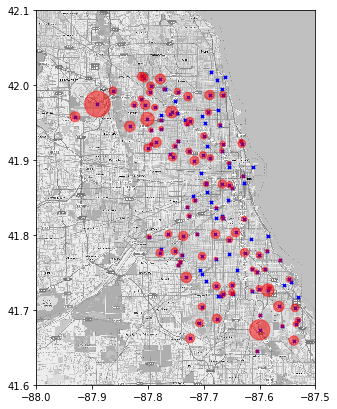

In [56]:
plt.figure(figsize=(5,7))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)
plt.scatter(location_cnt.Longitude, 
            location_cnt.Latitude, 
            marker='x',
            s=10,
            c='blue')
plt.scatter(pos_location_cnt.Longitude, 
            pos_location_cnt.Latitude, 
            s = 10*pos_location_cnt.Count,  
            alpha=0.5,
            c='red')

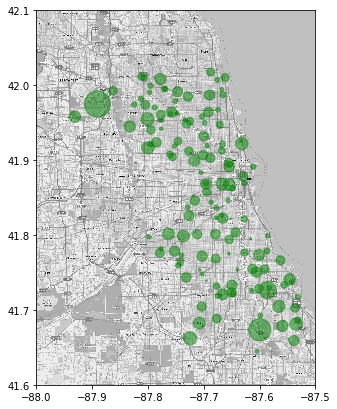

In [57]:
plt.figure(figsize=(5,7))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)
plt.scatter(neg_location_cnt.Longitude, 
            neg_location_cnt.Latitude, 
            s = 1*neg_location_cnt.Count,  
            alpha=0.5,
            c='green')

Some traps have more records over the years than others. And while all traps have negative presence, only have positive presence. It is useful to normalize the percentage of positive presence for each trap. There are also satellite traps, such as 'T054','T054C'

In [58]:
location_cnt = traps.groupby(['Longitude', 'Latitude'],as_index=False).count()[['Longitude', 'Latitude','Date']].rename(columns={'Date':'Count'})
pos_location_cnt = pos_traps.groupby(['Longitude', 'Latitude'],as_index=False).count()[['Longitude', 'Latitude','Date']].rename(columns={'Date':'Count'})
neg_location_cnt = neg_traps.groupby(['Longitude', 'Latitude'],as_index=False).count()[['Longitude', 'Latitude','Date']].rename(columns={'Date':'Count'})

In [59]:
pos_total_location_cnt = pd.merge(location_cnt,pos_location_cnt,on=['Longitude', 'Latitude'],how='left')
pos_total_location_cnt['Positive_Perc'] = pos_total_location_cnt['Count_y'] / pos_total_location_cnt['Count_x'] 

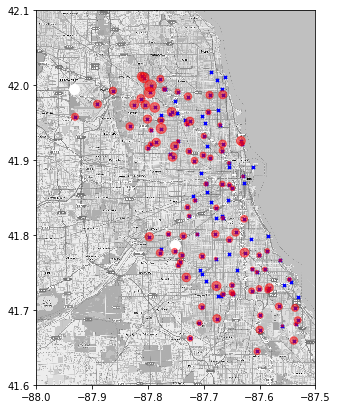

In [60]:
plt.figure(figsize=(5,7))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)
plt.scatter(station1[0],station1[1], s=100, c='white')
plt.scatter(station2[0],station2[1], s=100, c='white')
plt.scatter(location_cnt.Longitude, 
            location_cnt.Latitude, 
            marker='x',
            s=10,
            c='blue')
plt.scatter(pos_total_location_cnt.Longitude, 
            pos_total_location_cnt.Latitude, 
            s = 700*pos_total_location_cnt.Positive_Perc,
            alpha=0.5,
            c='red')

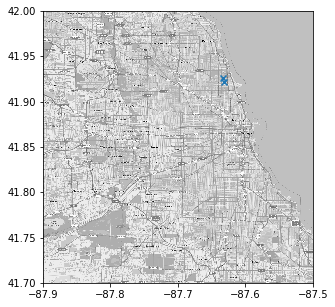

In [61]:
plt.figure(figsize=(5,5))
lon_lat_box = (-87.9, -87.5, 41.7, 42) # very close to each other in satellite location
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)
satellite = traps[(traps.Trap=='T054')| (traps.Trap =='T054C')]
satellites = satellite[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(satellites[:,0], satellites[:,1], marker='x')

In [62]:
location_cnt.Count.describe()

count    138.000000
mean      76.130435
std       86.952611
min        2.000000
25%       23.250000
50%       62.500000
75%      103.750000
max      750.000000
Name: Count, dtype: float64

In [63]:
neg_location_cnt.Count.describe()

count    138.000000
mean      72.137681
std       80.428251
min        2.000000
25%       23.000000
50%       58.500000
75%       94.750000
max      684.000000
Name: Count, dtype: float64

In [64]:
pos_location_cnt.Count.describe()

count    99.000000
mean      5.565657
std       7.956722
min       1.000000
25%       2.000000
50%       4.000000
75%       7.000000
max      66.000000
Name: Count, dtype: float64

In [65]:
pos_total_location_cnt.Positive_Perc.describe()

count    99.000000
mean      0.060449
std       0.037299
min       0.007752
25%       0.032154
50%       0.050955
75%       0.084211
max       0.193548
Name: Positive_Perc, dtype: float64

After normalization to total records for each trap, it seems the positive ratio varies less for each trap. Some traps do not have any presence at all.
In addition, some traps are satellite traps, such may subtitute with single trap name. 

In [66]:
# spray data

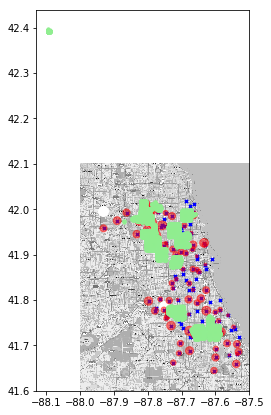

In [67]:
plt.figure(figsize=(5,7))
lon_lat_box = (-88, -87.5, 41.6, 42.1)
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)
plt.scatter(station1[0],station1[1], s=100, c='white')
plt.scatter(station2[0],station2[1], s=100, c='white')
plt.scatter(location_cnt.Longitude, 
            location_cnt.Latitude, 
            marker='x',
            s=10,
            c='blue')
plt.scatter(pos_total_location_cnt.Longitude, 
            pos_total_location_cnt.Latitude, 
            s = 700*pos_total_location_cnt.Positive_Perc,
            alpha=0.5,
            c='red')

spray_locations = spray[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(spray_locations[:,0], spray_locations[:,1],c ='lightgreen',s = 10,alpha=0.7)
# apparently, there are some spray data outside Chicago, need to filter out spray data

In [68]:
# filter spray data in chicago only
spray_chicago = spray[(spray['Longitude'] < -87.5) & (spray['Longitude'] > -88 ) & \
                      (spray['Latitude'] < 42.1) & (spray['Latitude'] > 41.6) ].copy()

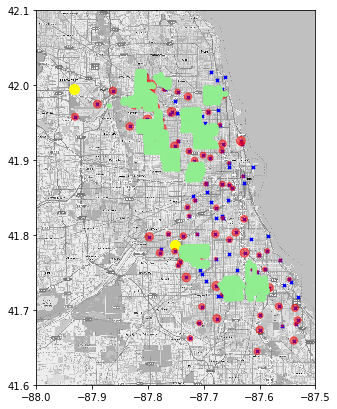

In [69]:
plt.figure(figsize=(5,7))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)
plt.scatter(station1[0],station1[1], s=100, c='yellow')
plt.scatter(station2[0],station2[1], s=100, c='yellow')
plt.scatter(location_cnt.Longitude, 
            location_cnt.Latitude, 
            marker='x',
            s=10,
            c='blue')
plt.scatter(pos_total_location_cnt.Longitude, 
            pos_total_location_cnt.Latitude, 
            s = 700*pos_total_location_cnt.Positive_Perc,
            alpha=0.5,
            c='red')

spray_locations = spray_chicago [['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(spray_locations[:,0], spray_locations[:,1],c ='lightgreen',s = 10,alpha=0.7)
# apparently, there are some spray data outside Chicago, need to filter out spray data

When on the same day of measurement, if there is spray, it would affect the measured number of mosquitos. This suggests that spray yes or no for a given position and the number of mosquitos in a trap can be correlated features. When building models, their correlation could be captured by a neural net. Could feed all to a neural net to build classification model measured by AUCROC (in model selection). 

In [70]:
# species, some species can be more infectious, all in the same family
train.groupby('Species',as_index=False).count()[['Species', 'Date']].rename(columns={'Date':'Count'})

,Species,Count
0,CULEX ERRATICUS,1
1,CULEX PIPIENS,2699
2,CULEX PIPIENS/RESTUANS,4752
3,CULEX RESTUANS,2740
4,CULEX SALINARIUS,86
5,CULEX TARSALIS,6
6,CULEX TERRITANS,222


West Nile virus is most commonly spread to people by the bite of an infected mosquito.
Mosquitoes become infected when they feed on infected birds. Infected mosquitoes then spread West Nile virus to people and other animals by biting them.
Park with a lot of trees ==> where birds are

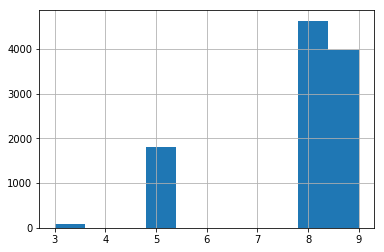

In [71]:
train.AddressAccuracy.hist()

The higher the dew point rises, the greater the amount of moisture in the air. This directly effects how "comfortable" it will feel outside. Many times, relative humidity can be misleading. 

In [72]:
# spray.groupby('Date',as_index=False).count().sort_values('Date')
# spray.sort_values('Time').head()
# spray.sort_values('Time').tail()
# spray.Date.unique()

# 2. Feature engineering
## 2.1 featurize weathers
TBD (int, datetime, satellite, etc, embed categories, extract zipcode)
when: time of the day, day of the week, temperature, humidify of the day
where: trap, longtitude, latitude    

In [73]:
from scipy.spatial import distance
def nearest_weather_station(coordinate, station1, station2):
    coordinate_list = coordinate.split(',')
    long = float(coordinate_list[0])
    lat = float(coordinate_list[1])
    current = [long, lat]
    dist1 = distance.euclidean(current,station1)
    dist2 = distance.euclidean(current,station2)
    if dist1 < dist2: return 1
    else: return 2

In [74]:
def transform_data(df, weather_new, station1, station2):
    # get nearest weather stop
    df['Coordinate'] = df['Longitude'].astype(str) + "," + df['Latitude'].astype(str)
    df['Station'] = df['Coordinate'].apply(lambda x: nearest_weather_station(x, station1, station2))
    df_with_weather = pd.merge(df, weather_new, on= ['Date','Station'])
    generate_date_features(df_with_weather)
    return df_with_weather

In [76]:
train_with_weather.shape

(10506, 45)

In [77]:
test_with_weather.shape # one less column with the label, but it also contains Id

(116293, 44)

In [78]:
train_with_weather.to_csv('train_with_weather_v1.csv',index=False)
test_with_weather.to_csv('test_with_weather_v1.csv',index=False)

# train with automl OR just build a XGboost model

In [3]:
import h2o
h2o.init()
from h2o.automl import H2OAutoML
from h2o import *

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_152"; Java(TM) SE Runtime Environment (build 1.8.0_152-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.152-b16, mixed mode)
  Starting server from /Users/juyang/anaconda2/lib/python2.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/5k/79rc2t750_l4ld5z9jvlbcqh0000gn/T/tmpWMgi6w
  JVM stdout: /var/folders/5k/79rc2t750_l4ld5z9jvlbcqh0000gn/T/tmpWMgi6w/h2o_juyang_started_from_python.out
  JVM stderr: /var/folders/5k/79rc2t750_l4ld5z9jvlbcqh0000gn/T/tmpWMgi6w/h2o_juyang_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.8
H2O cluster version age:,7 months and 14 days !!!
H2O cluster name:,H2O_from_python_juyang_i1c0ta
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


TypeError: Item in ``from list'' must be str, not unicode

In [4]:
train_data =  h2o.import_file(path = 'train_with_weather_v1.csv')
test_data =  h2o.import_file(path = 'test_with_weather_v1.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
# highly correlated, find out how it works
train[['NumMosquitos','WnvPresent']].corr()

,NumMosquitos,WnvPresent
NumMosquitos,1.00000,0.19682
WnvPresent,0.19682,1.00000


features
1. train with training data alone (geo features)
2. train with weather data
3. train additional with other data

categorical data
1. one-hot
2. string encoder
3. embedding

In [7]:
features  = [#'Date', 
             'Species', 
             'Block', 
       'Latitude', 'Longitude', 'AddressAccuracy',
       #'NumMosquitos', 
        'Station', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Depth',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'Sunrise_time', 'Sunrise_hour',
       'Sunrise_minute', 'Sunset_time', 'Sunset_hour', 'Sunset_minute', 'Year',
       'Month', 'DayOfMonth', 'DayOfWeekName', 'DayOfWeek', 'DayOfYear',
       'WeekOfYear', 'IsLeadYear', 'Quarter']
label = 'WnvPresent'

In [8]:
# treat label as classification
train_data[label] = train_data[label].asfactor()
# test_data[label] = test_data[label].asfactor()

In [141]:
# need to deal with missing categorical values in test
# also need to use difference features in test!!!!!!
# no more mosquitos number for predictor
# construct mosquitos numbers?

In [142]:
# use xgboost to train

In [9]:
from h2o.estimators import H2OXGBoostEstimator

param = {
      "ntrees" : 100,
      "max_depth" : 8,
      "learn_rate" : 0.005,
      "sample_rate" : 0.7,
      "col_sample_rate_per_tree" : 0.9,
      "min_rows" : 5,
      "seed": 42,
      "score_tree_interval": 100
}
model = H2OXGBoostEstimator(**param)
model.train(x=features, 
          y=label, 
          training_frame=train_data)
#https://www.h2o.ai/blog/xgboost-in-h2o-machine-learning-platform/
# train without number mosquitios

xgboost Model Build progress: |███████████████████████████████████████████| 100%


# what happened to unseen values?
Should treat it as additional class
Unseen categorical levels are turned into NAs, and thus follow the same behavior as an NA. If there are no NAs in the training data, then unseen categorical levels in the test data follow the majority direction (the direction with the most observations). 
If there are NAs in the training data, then unseen categorical levels in the test data follow the direction that is optimal for the NAs of the training data.

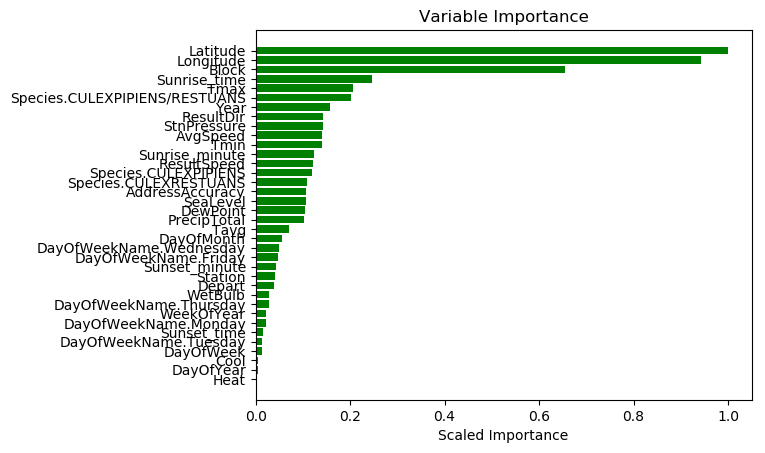

In [10]:
import matplotlib.pyplot as plt
plt.rcdefaults()
fig, ax = plt.subplots()
variables = model._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = model._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

In [ ]:
# need to have cross-validation to avoid overfitting
# separate CV set
# use scikit learn for basic N-fold
# train with RF model alone
# no much tuning

In [11]:
model.auc 
# 0.8659415646270285
# 1 has a lot of misclassified
# auc is not properly defined tp, fp

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1557151530670_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.117737987948
RMSE: 0.343129695521
LogLoss: 0.416909886147
Mean Per-Class Error: 0.170374489194
AUC: 0.914212868981
Gini: 0.828425737962
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.375680210732: 


,0,1,Error,Rate
0,9432.0,523.0,0.0525,(523.0/9955.0)
1,263.0,288.0,0.4773,(263.0/551.0)
Total,9695.0,811.0,0.0748,(786.0/10506.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3756802,0.4229075,138.0
max f2,0.3524437,0.5481911,191.0
max f0point5,0.4072198,0.4489796,83.0
max accuracy,0.4855324,0.9497430,20.0
max precision,0.5447986,1.0,0.0
max recall,0.3110635,1.0,344.0
max specificity,0.5447986,1.0,0.0
max absolute_mcc,0.3524437,0.4033435,191.0
max min_per_class_accuracy,0.3364278,0.8263184,238.0
max mean_per_class_accuracy,0.3253664,0.8296255,279.0


Gains/Lift Table: Avg response rate:  5.24 %, avg score: 32.37 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0103750,0.4547362,11.0204632,11.0204632,0.5779817,0.4914305,0.5779817,0.4914305,0.1143376,0.1143376,1002.0463211,1002.0463211
,2,0.0200838,0.4207057,9.7205082,10.3920489,0.5098039,0.4320511,0.5450237,0.4627258,0.0943739,0.2087114,872.0508167,939.2048924
,3,0.0300781,0.4035771,8.5348198,9.7749317,0.4476190,0.4110461,0.5126582,0.4455537,0.0852995,0.2940109,753.4819808,877.4931655
,4,0.0400723,0.3942116,5.8109411,8.7862879,0.3047619,0.3994273,0.4608076,0.4340495,0.0580762,0.3520871,481.0941146,778.6287941
,5,0.0517799,0.3885915,4.1854721,7.7460299,0.2195122,0.3908133,0.40625,0.4242737,0.0490018,0.4010889,318.5472091,674.6029946
,6,0.1000381,0.3649388,4.2120727,6.0412571,0.2209073,0.3758020,0.3168411,0.4008910,0.2032668,0.6043557,321.2072724,504.1257052
,7,0.1500095,0.3480522,2.7965154,4.9603628,0.1466667,0.3554072,0.2601523,0.3857394,0.1397459,0.7441016,179.6515427,396.0362792
,8,0.2000761,0.3377287,1.2687268,4.0365757,0.0665399,0.3427615,0.2117031,0.3749847,0.0635209,0.8076225,26.8726753,303.6575658
,9,0.3000190,0.3239058,1.1621882,3.0790545,0.0609524,0.3305119,0.1614848,0.3601698,0.1161525,0.9237750,16.2188229,207.9054465
,10,0.4000571,0.3150638,0.6349670,2.4678872,0.0333016,0.3190585,0.1294314,0.3498895,0.0635209,0.9872958,-36.5033043,146.7887210



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2019-05-06 10:05:59,0.024 sec,0.0,0.5,0.6931472,0.5,1.0,0.9475538
,2019-05-06 10:06:02,3.368 sec,100.0,0.3431297,0.4169099,0.9142129,11.0204632,0.0748144


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Latitude,1667.0,1.0,0.1860283
Longitude,1573.0,0.9436113,0.1755384
Block,1092.0,0.6550690,0.1218614
Sunrise_time,410.0,0.2459508,0.0457538
Tmax,342.0,0.2051590,0.0381654
---,---,---,---
DayOfWeekName.Tuesday,22.0,0.0131974,0.0024551
DayOfWeek,22.0,0.0131974,0.0024551
Cool,8.0,0.0047990,0.0008928
DayOfYear,7.0,0.0041992,0.0007812



See the whole table with table.as_data_frame()


<bound method H2OXGBoostEstimator.auc of >

In [12]:
pred_xgboost = model.predict(test_data)
pred_xgboost_df = pred_xgboost.as_data_frame()

xgboost prediction progress: |████████████████████████████████████████████| 100%


/Users/juyang/anaconda2/lib/python2.7/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'Species' has levels not trained on: [UNSPECIFIED CULEX]
  warnings.warn(w)


In [13]:
sample = pd.read_csv('input/sampleSubmission.csv')
sample['WnvPresent'] = pred_xgboost_df['predict']
sample.WnvPresent.value_counts() # whhhhhhy it works here but not using standard RF???

0    111625
1      4668
Name: WnvPresent, dtype: int64

In [148]:
sample.to_csv('prediction_v6.csv', index=False)